# ECE 493 Assignment 3

Assignment Overview
- Learn pytorch and helper libraries
- Understand VOC Sementic Segmentation Dataset
- Create data transforms to augment the dataset
- Create the neural network
- Train and evaluate the neural network

Problems:
- 1) Data augmentation
- 2) Create the neural network

Note:
- This assignment was created based on assignment 4 of CS 484
 - https://cs.uwaterloo.ca/~yboykov/Courses/cs484/

# Importing libraries

Everything that you need for this assignment is imported here.

The VoxSegmentation dataset contains images and segmented images.
https://chainercv.readthedocs.io/en/stable/reference/datasets.html#chainercv.datasets.VOCSemanticSegmentationDataset


In [1]:
# You can run this cell to install packages
# I believe this is the only package not preinstalled on google colab
!pip install chainercv

In [2]:
# pytorch library
import torch
# neural network layers (Conv2d, Linear, etc.) that will be trained
# https://pytorch.org/docs/stable/nn.html
import torch.nn as nn
# Many functions (convolution, pooling, activation, etc.)
# https://pytorch.org/docs/stable/nn.functional.html
import torch.nn.functional as F
# https://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader
from torch.utils.data import DataLoader

# Contains pretrained models for transfer learning
# https://pytorch.org/docs/stable/torchvision/models.html
import torchvision.models as models
# import data transforms
# https://pytorch.org/docs/stable/torchvision/transforms.html
# Take note of transforms.ToPILImage and transforms.ToTensor
import torchvision.transforms as transforms


# Use cuda on the gpu or use the cpu
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
# Overide device when testing on CPU
# device = 'cpu'

# graphing and images
import matplotlib.pyplot as plt
from PIL import Image

# numpy
import numpy as np

# deepcopy the nn
import copy

# for random number generation
import random

# chainerCV is similar to torchvision
import chainercv
# https://chainercv.readthedocs.io/en/stable/reference/datasets.html#chainercv.datasets.VOCSemanticSegmentationDataset
from chainercv.datasets import VOCSemanticSegmentationDataset
# https://docs.chainer.org/en/stable/reference/generated/chainer.datasets.TransformDataset.html#chainer.datasets.TransformDataset
from chainer.datasets import TransformDataset

# Used to calculate mIoU
from chainercv.evaluations import eval_semantic_segmentation



# Import VOC Segmentation Dataset

In [3]:
import os.path
from os import path
from google.colab import drive

drive.mount('/content/gdrive')
DATASET_LOCATION = '/content/gdrive/MyDrive/'

if not path.exists(DATASET_LOCATION + 'VOC2012'):
  print('First time run, downloading VOC and copying to permanent location')
  # auto will download the dataset to $HOME/.chainer/dataset
  # This gets deleted when you disconnect from google colab
  voc_train_data = VOCSemanticSegmentationDataset(data_dir='auto', split='train')
  !cp -r $HOME/.chainer/dataset/pfnet/chainercv/voc/VOCdevkit/VOC2012/ /content/gdrive/MyDrive/

# Instantiate the data loader with the dataset directory
voc_train_data = VOCSemanticSegmentationDataset(data_dir=DATASET_LOCATION + 'VOC2012', split='train')

print("Number of training examples:", len(voc_train_data))
print("Each with one image and one ground truth (gt) segmented image:", len(voc_train_data[0]))

print("Image Shape:", voc_train_data[0][0].shape)
print("Segmented Image Shape:", voc_train_data[0][1].shape)

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
Number of training examples: 1464
Each with one image and one ground truth (gt) segmented image: 2
Image Shape: (3, 281, 500)
Segmented Image Shape: (281, 500)


There are 22 Classes in VOC.

https://github.com/NVIDIA/DIGITS/blob/master/examples/semantic-segmentation/pascal-voc-classes.txt
- -1 is ignore
- 0 is background
- 1-20 are different objects

View count of pixels within each label category:
(array([-1,  0,  7, 15], dtype=int32), array([  4943, 142234,  15733,   3590]))
(array([-1,  0,  7, 15], dtype=int32), array([  3684, 150374,  32709,    733]))
(array([-1,  0,  2,  7, 15], dtype=int32), array([ 12802, 164053,   4518,    673,   5454]))
We must move the RGB channel to the back to be viewed with plt:
Before: (3, 333, 500)
After: (333, 500, 3)
Lastly let's verify that the image and gt label match


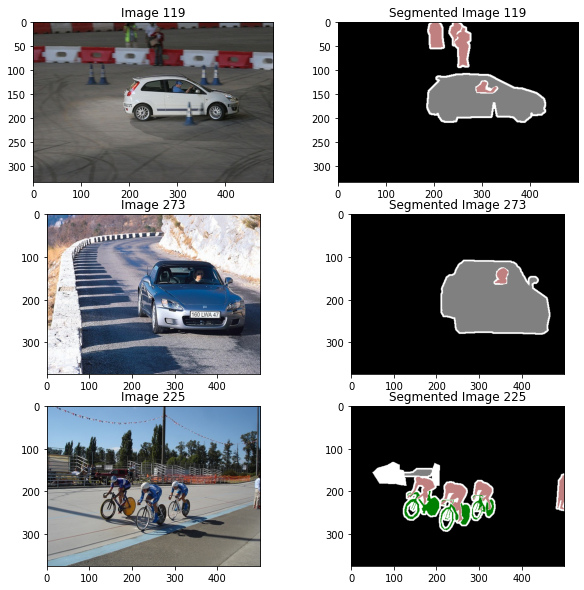

In [4]:
# Find images with people and cars
def find_car_and_ppl_images():
    car_label = 7
    person_label = 15
    count = 0
    max_count = 100
    for i in range(len(voc_train_data)):
        tmp_count = np.unique(voc_train_data[i][1], return_counts=True)
        if car_label in tmp_count[0] and person_label in tmp_count[0]:
            if count == max_count:
                break
            else:
                img, label = voc_train_data[i]
                fig = plt.figure(figsize=(4,3))
                ax = fig.add_subplot(1,1,1)
                plt.title('Image ' + str(i))
                ax.imshow(np.rollaxis(img.astype(int), 0, 3))
                count += 1

# I used this function to find some relevant images
# find_car_and_ppl_images()

# Some relevant image indexes for a self-driving car
# Car = 119, 273, Bicycle = 225
img_119, seg_img_119 = voc_train_data[119]
img_273, seg_img_273 = voc_train_data[273]
img_225, seg_img_225 = voc_train_data[225]

print("View count of pixels within each label category:")
print(np.unique(voc_train_data[119][1], return_counts=True))
print(np.unique(voc_train_data[273][1], return_counts=True))
print(np.unique(voc_train_data[225][1], return_counts=True))

print("We must move the RGB channel to the back to be viewed with plt:")
print("Before:", img_119.shape)
print("After:", np.rollaxis(img_119, 0, 3).shape)

print("Lastly let's verify that the image and gt label match")

# This colorize_mask class takes in a numpy segmentation mask,
#  and then converts it to a PIL Image for visualization.
#  Since by default the numpy matrix contains integers from
#  0,1,...,num_classes, we need to apply some color to this
#  so we can visualize easier! Refer to:
#  https://pillow.readthedocs.io/en/4.1.x/reference/Image.html#PIL.Image.Image.putpalette
palette = [0, 0, 0, 128, 0, 0, 0, 128, 0, 128, 128, 0, 0, 0, 128, 128, 0, 128, 0, 128, 128,
           128, 128, 128, 64, 0, 0, 192, 0, 0, 64, 128, 0, 192, 128, 0, 64, 0, 128, 192, 0, 128,
           64, 128, 128, 192, 128, 128, 0, 64, 0, 128, 64, 0, 0, 192, 0, 128, 192, 0, 0, 64, 128]

def colorize_mask(mask):
    new_mask = Image.fromarray(mask.astype(np.uint8)).convert('P')
    new_mask.putpalette(palette)

    return new_mask

def add_img_plot(fig, index, img, title, sub_plot_id):
    ax = fig.add_subplot(sub_plot_id[0],sub_plot_id[1],sub_plot_id[2])
    plt.title(title + str(index))
    ax.imshow(img)

# Create the figure size
fig = plt.figure(figsize=(10,10))
# Car image 119
add_img_plot(fig, 119, np.rollaxis(img_119.astype(int), 0, 3), 'Image ', [3,2,1])
add_img_plot(fig, 119, colorize_mask(seg_img_119), 'Segmented Image ', [3,2,2])
# Car image 273
add_img_plot(fig, 273, np.rollaxis(img_273.astype(int), 0, 3), 'Image ', [3,2,3])
add_img_plot(fig, 273, colorize_mask(seg_img_273), 'Segmented Image ', [3,2,4])
# Bicycle image 225
add_img_plot(fig, 225, np.rollaxis(img_225.astype(int), 0, 3), 'Image ', [3,2,5])
add_img_plot(fig, 225, colorize_mask(seg_img_225), 'Segmented Image ', [3,2,6])

# Problem 1 Data Augmentation

The transform below is used to create a transformed training dataset. It currently center crops all images.

Modify it so that:
- There is a 50% chance the images will be flipped horizontally
- Instead of a center crop, a random part of the image is cropped

Useful functions:
- chainercv.transforms.flip
- chainercv.transforms.random_crop

Note: The output image and segmented images should match

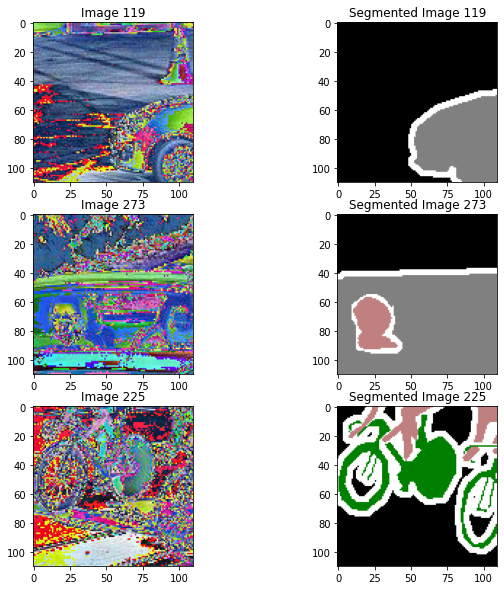

In [5]:
# From ImageNet
norm = ([0.485, 0.456, 0.406], 
        [0.229, 0.224, 0.225])

# Modify this function
def voc_train_transform(in_data):
    size = (110,110)
    img, seg_img = in_data

    # Add channel
    seg_img = seg_img[None]

    if np.random.binomial(1, 0.5):
      img = chainercv.transforms.flip(img, x_flip=True)
      seg_img = chainercv.transforms.flip(seg_img, x_flip=True)

    img, params = chainercv.transforms.random_crop(img, size, return_param=True)
    img = np.rollaxis(img, 0, 3)
    img = transforms.ToPILImage()(np.uint8(img))
    img = transforms.ToTensor()(img)
    img = transforms.Normalize(norm[0],norm[1])(img)

    seg_img = seg_img[:, params['y_slice'], params['x_slice']][0]


    return img, torch.from_numpy(seg_img.copy()).long()

img_119, seg_img_119 = voc_train_transform(voc_train_data[119])
img_273, seg_img_273 = voc_train_transform(voc_train_data[273])
img_225, seg_img_225 = voc_train_transform(voc_train_data[225])

# Create the figure size
fig = plt.figure(figsize=(10,10))
# Car image 119
add_img_plot(fig, 119, transforms.ToPILImage()(img_119), 'Image ', [3,2,1])
add_img_plot(fig, 119, colorize_mask(seg_img_119.numpy()), 'Segmented Image ', [3,2,2])
# Car image 273
add_img_plot(fig, 273, transforms.ToPILImage()(img_273), 'Image ', [3,2,3])
add_img_plot(fig, 273, colorize_mask(seg_img_273.numpy()), 'Segmented Image ', [3,2,4])
# Bicycle image 225
add_img_plot(fig, 225, transforms.ToPILImage()(img_225), 'Image ', [3,2,5])
add_img_plot(fig, 225, colorize_mask(seg_img_225.numpy()), 'Segmented Image ', [3,2,6])

# Dataloader

In [6]:
voc_train_data_transformed = TransformDataset(voc_train_data, voc_train_transform)

# epoch = one iteration over the entire dataset
# batch size = samples per batch within an epoch
# shuffle = Set to True if your data is ordered
# num_workers = number of subprocess to use when dataloading, set higher if you have many cpu cores
if device == 'cpu':
    train_loader = DataLoader(voc_train_data_transformed, batch_size=5, shuffle=True, num_workers=10)
else:
    train_loader = DataLoader(voc_train_data_transformed, batch_size=50, shuffle=True, num_workers=2)

# Problem 2 Create the neural network

In [7]:
def print_size(x, string, test_mode):
    if test_mode:
        print(string)
        print(x.size())

In [8]:
class Net(nn.Module):
    def __init__(self, num_classes, criterion=None):
        super(Net, self).__init__()
        self.criterion = criterion
        self.num_classes = num_classes

        # Hints:
        # Useful layers to train
        # - nn.Conv2d
        # - nn.BatchNorm2d
        # - nn.Dropout2d
        # You can import a pre-trained model
        self.resnet = models.resnet34(pretrained=True)
        self.conv1 = nn.Conv2d(576, 512, 3, 1)
        self.conv2 = nn.Conv2d(512, 21, 1, 1)
        self.bn1 = nn.BatchNorm2d(512)
        self.bn2 = nn.BatchNorm2d(21)
        self.dropout1 = nn.Dropout2d(0.5)


    def forward(self, inp, gts=None):
        # Fill in

        # Hints: Useful functions
        # - F.relu        (neuron activation)
        # - F.interpolate (interpolate to increase tensor H and W)
        # - torch.cat     (concatonate tensors to implement a skip connection)
        test = False

        print_size(inp, "Inpuut", test)
        output_size = (inp.size()[2], inp.size()[3])

        x = self.resnet.conv1(inp)
        x = self.resnet.bn1(x)
        x = self.resnet.relu(x)
        x = self.resnet.maxpool(x)
        print_size(x, "Resnet conv1 complete", test)

        x = self.resnet.layer1(x)
        print_size(x, "Layer 1 complete", test)
        skip_connection = x

        x = self.resnet.layer2(x)
        print_size(x, "Layer 2 complete", test)

        x = self.resnet.layer3(x)
        print_size(x, "Layer 3 complete", test)

        x = self.resnet.layer4(x)
        print_size(x, "Layer 4 complete", test)

        x = F.interpolate(x, size=skip_connection.size()[2:], mode='bicubic')
        print_size(x, "Interpolate 1 complete", test)

        x = torch.cat((x, skip_connection), 1)
        print_size(x, "Concat complete", test)

        x = self.conv1(x)
        print_size(x, "Conv 1 complete", test)

        x = self.bn1(x)
        print_size(x, "BN 1 complete", test)

        x = F.relu(x)

        x = self.dropout1(x)
        print_size(x, "Dropout 1 complete", test)

        x = F.interpolate(x, size=output_size, mode='bilinear')
        print_size(x, "Interpolate 2 complete", test)

        x = self.conv2(x)
        print_size(x, "Conv 2 complete", test)

        x = self.bn2(x)
        print_size(x, "BN 2 complete", test)

        lfinal = x


        if self.training:
            # Return the loss if in training mode
            return self.criterion(lfinal, gts)
        else:
            # Return the actual prediction otherwise
            return lfinal


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3063: UserWarning: Default upsampling behavior when mode=bicubic is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))
/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3063: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


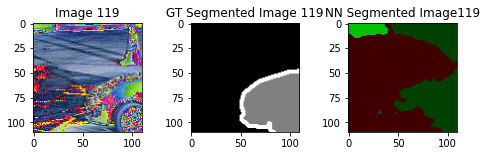

In [9]:
untrained_net = Net(21).to(device)
untrained_net.eval()

sample_img, sample_target = voc_train_data_transformed[119]

untrained_output = untrained_net.forward(sample_img[None].to(device))
if device != 'cpu':
    untrained_output = untrained_output.cpu()
untrained_nn_seg_img_119 = torch.argmax(untrained_output.cpu(), dim=1).numpy()[0]

# Create the figure size
fig = plt.figure(figsize=(8,2))
# Car image 119
add_img_plot(fig, 119, transforms.ToPILImage()(img_119), 'Image ', [1,3,1])
add_img_plot(fig, 119, colorize_mask(seg_img_119.numpy()), 'GT Segmented Image ', [1,3,2])
add_img_plot(fig, 119, colorize_mask(untrained_nn_seg_img_119), 'NN Segmented Image', [1,3,3])

In [10]:
def train(train_loader, net, optimizer, loss_graph, device):

    for batch_idx, (data, target) in enumerate(train_loader):
        img, gt_seg_img = data.to(device), target.to(device)

        # This is a forward pass which also returns loss due to training mode
        main_loss = net(img, gts=gt_seg_img)

        # Populate this list to graph the loss
        loss_graph.append(main_loss.item())
        
        # View the loss within the epoch
        print(main_loss.item())

        # Zero gradients, perform a backward pass, and update the weights.
        optimizer.zero_grad()
        main_loss.backward()
        optimizer.step()
        
    return main_loss

In [11]:
# You may switch the optimizer
def get_optimizer(net):
    optimizer = torch.optim.SGD(net.parameters(),
                                lr=0.1, # 0.001
                                weight_decay=1e-5,
                                momentum=0.5,
                                nesterov=False)
    return optimizer

Starting Training...


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3063: UserWarning: Default upsampling behavior when mode=bicubic is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))
/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3063: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


3.5616681575775146
2.818601131439209
2.6596405506134033
2.44888973236084
2.221266269683838
2.1547889709472656
1.9334057569503784
2.137843132019043
1.9366559982299805
1.7955739498138428
1.9394696950912476
1.583747148513794
1.6660926342010498
1.6111280918121338
1.5612976551055908
1.3961901664733887
1.5308854579925537
1.4681535959243774
1.3876209259033203
1.833042025566101
1.3330217599868774
1.5736984014511108
1.4859715700149536
1.2986600399017334
1.2653769254684448
1.1590996980667114
1.2656238079071045
1.4312407970428467
1.3254916667938232
1.479725956916809
Epoch: 0 Loss: 1.479725956916809
1.313437581062317
1.2487456798553467
1.38140869140625
1.308666706085205
1.0798207521438599
0.942026674747467
1.3321757316589355
1.2245168685913086
1.3059163093566895
1.0074650049209595
0.9898435473442078
1.056944727897644
1.1442195177078247
1.296639323234558
1.0764484405517578
1.108984351158142
1.2596032619476318
1.2388445138931274
1.2152212858200073
1.0360866785049438
1.181133508682251
0.8864979147911

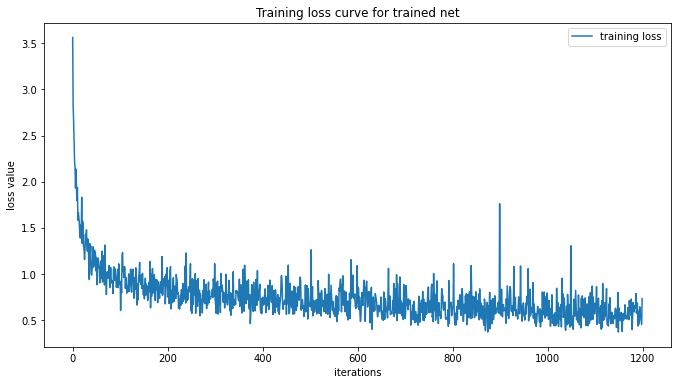

In [12]:
%%time
%matplotlib inline

# Deep copy in order to train the network with the same initialized weights
trained_net = copy.deepcopy(untrained_net)
trained_net = trained_net.to(device)

# set loss function for the net
trained_net.criterion = nn.CrossEntropyLoss(ignore_index=-1)

# You can change the number of EPOCHS
EPOCH = 40

# switch to train mode (original untrained_net was set to eval mode)
trained_net.train()

optimizer = get_optimizer(trained_net)

print("Starting Training...")

loss_graph = []

fig = plt.figure(figsize=(12,6))
plt.subplots_adjust(bottom=0.2,right=0.85,top=0.95)
ax = fig.add_subplot(1,1,1)

for e in range(EPOCH):
    loss = train(train_loader, trained_net, optimizer, loss_graph, device)
    ax.clear()
    ax.set_xlabel('iterations')
    ax.set_ylabel('loss value')
    ax.set_title('Training loss curve for trained net')
    ax.plot(loss_graph, label='training loss')
    ax.legend(loc='upper right')
    fig.canvas.draw()
    print("Epoch: {} Loss: {}".format(e, loss))


In [13]:
def validate(val_loader, net):
    iou_arr = []
    val_loss = 0

    net.eval()

    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(val_loader):
            img, gt_seg_img = data.to(device), target.to(device)

            output = net(img)

            # Convert to numpy arrays
            if device != 'cpu':
                output = output.cpu()
                gt_seg_img = gt_seg_img.cpu()
            pred = torch.argmax(output, dim=1).numpy()[0]

            gt_np = gt_seg_img.numpy()[0]

            conf = eval_semantic_segmentation(pred[None], gt_np[None])

            iou_arr.append(conf['miou'])
    
    return val_loss, (sum(iou_arr) / len(iou_arr))

# Validation

In [14]:
# a validation loader is created with a transform that doesn't modify the data
voc_val_data = VOCSemanticSegmentationDataset(data_dir=DATASET_LOCATION + 'VOC2012', split='val')

def val_transform(in_data):
    img, seg_img = in_data

    img = np.rollaxis(img, 0, 3)
    img = transforms.ToPILImage()(np.uint8(img))
    img = transforms.ToTensor()(img)
    img = transforms.Normalize(mean=norm[0],std=norm[1])(img)

    return img, torch.from_numpy(seg_img).long()

voc_val_data_transformed = TransformDataset(voc_val_data, val_transform)

# epoch = one iteration over the entire dataset
# batch size = samples per batch within an epoch
# shuffle = Set to True if your data is ordered
# num_workers = number of subprocess to use when dataloading, set higher if you have many cpu cores
val_loader = DataLoader(voc_val_data_transformed, batch_size=1, shuffle=True, num_workers=10)

In [15]:
%%time
print("mIoU over the training dataset:{}".format(validate(train_loader, trained_net)[1]))

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3063: UserWarning: Default upsampling behavior when mode=bicubic is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))
/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3063: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))
/usr/local/lib/python3.6/dist-packages/chainercv/evaluations/eval_semantic_segmentation.py:91: RuntimeWarning: invalid value encountered in true_divide
  iou = np.diag(confusion) / iou_denominator
/usr/local/lib/python3.6/dist-packages/chainercv/evaluations/eval_semantic_segmentatio

mIoU over the training dataset:0.6555690597257293
CPU times: user 10.3 s, sys: 1.22 s, total: 11.5 s
Wall time: 16.6 s


In [16]:
%%time
print("mIoU over the validation dataset:{}".format(validate(val_loader, trained_net)[1]))

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3063: UserWarning: Default upsampling behavior when mode=bicubic is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))
/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3063: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))
/usr/local/lib/python3.6/dist-packages/chainercv/evaluations/eval_semantic_segmentation.py:91: RuntimeWarning: invalid value encountered in true_divide
  iou = np.diag(confusion) / iou_denominator
/usr/local/lib/python3.6/dist-packages/chainercv/evaluations/eval_semantic_segmentatio

mIoU over the validation dataset:0.4216969533209728
CPU times: user 1min 38s, sys: 14.9 s, total: 1min 53s
Wall time: 1min 54s


View count of pixels within each label category:
(array([-1,  0,  7, 15]), array([  4943, 142234,  15733,   3590]))
(array([ 0,  7, 15, 18]), array([128464,  16596,    404,  21036]))
View count of pixels within each label category:
(array([-1,  0,  7, 15]), array([  3684, 150374,  32709,    733]))
(array([0, 7]), array([153643,  33857]))


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3063: UserWarning: Default upsampling behavior when mode=bicubic is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))
/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3063: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))
/usr/local/lib/python3.6/dist-packages/chainercv/evaluations/eval_semantic_segmentation.py:91: RuntimeWarning: invalid value encountered in true_divide
  iou = np.diag(confusion) / iou_denominator
/usr/local/lib/python3.6/dist-packages/chainercv/evaluations/eval_semantic_segmentatio

View count of pixels within each label category:
(array([-1,  0,  2,  7, 15]), array([ 12802, 164053,   4518,    673,   5454]))
(array([ 0,  1,  2, 14, 15]), array([177349,    307,   5377,   1832,   2635]))


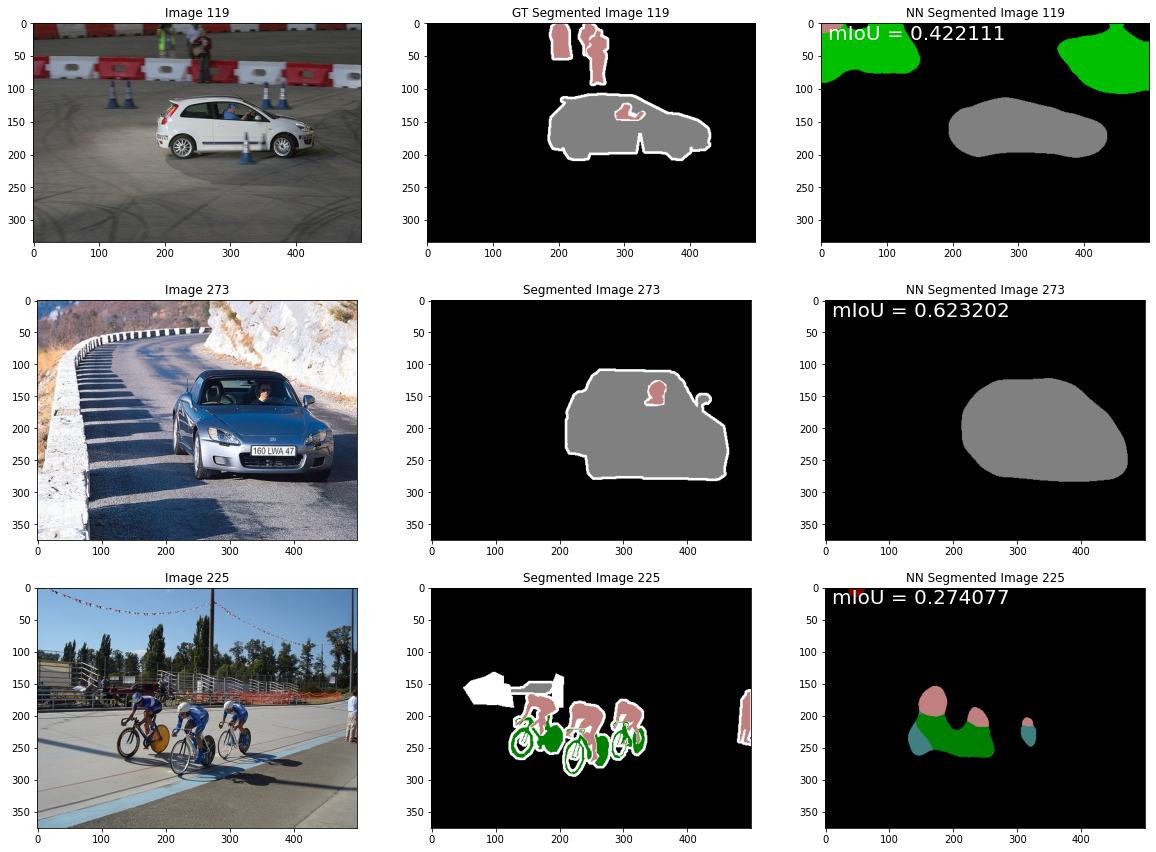

In [17]:
# switch back to evaluation mode
trained_net.eval()

def add_img_txt_plot(fig, index, img, title, sub_plot_id, txt):
    ax = fig.add_subplot(sub_plot_id[0],sub_plot_id[1],sub_plot_id[2])
    plt.title(title + str(index))
    ax.text(10, 25, 'mIoU = {:_>8.6f}'.format(txt), fontsize=20, color='white')
    ax.imshow(img)

def get_nn_seg_img(net, data):
    img, gt_seg_img = data

    nn_seg_output = net.forward(img[None].cuda())

    # computing mIOU (quantitative measure of accuracy for network predictions)
    if device != 'cpu':
        nn_seg_img = torch.argmax(nn_seg_output, dim=1).cpu().numpy()[0]
    else:
        nn_seg_img = torch.argmax(nn_seg_output, dim=1).numpy()[0]

    gts = gt_seg_img.cpu().numpy()

    conf = eval_semantic_segmentation(nn_seg_img[None], gts[None])

    print("View count of pixels within each label category:")
    print(np.unique(gt_seg_img, return_counts=True))
    print(np.unique(nn_seg_img, return_counts=True))

    return nn_seg_img, conf['miou']

# Some relevant image indexes for a self-driving car
# Car = 119, 273, Bicycle = 225
img_119, seg_img_119 = voc_train_data[119]
img_273, seg_img_273 = voc_train_data[273]
img_225, seg_img_225 = voc_train_data[225]

# Get NN Output
nn_seg_img_119, miou_119 = get_nn_seg_img(trained_net, val_transform(voc_train_data[119]))
nn_seg_img_273, miou_273 = get_nn_seg_img(trained_net, val_transform(voc_train_data[273]))
nn_seg_img_225, miou_225 = get_nn_seg_img(trained_net, val_transform(voc_train_data[225]))

# Create the figure size
fig = plt.figure(figsize=(20,15))
# Car image 119
add_img_plot(fig, 119, np.rollaxis(img_119.astype(int), 0, 3), 'Image ', [3,3,1])
add_img_plot(fig, 119, colorize_mask(seg_img_119), 'GT Segmented Image ', [3,3,2])
add_img_txt_plot(fig, 119, colorize_mask(nn_seg_img_119), 'NN Segmented Image ', [3,3,3], miou_119)
# Car image 273
add_img_plot(fig, 273, np.rollaxis(img_273.astype(int), 0, 3), 'Image ', [3,3,4])
add_img_plot(fig, 273, colorize_mask(seg_img_273), 'Segmented Image ', [3,3,5])
add_img_txt_plot(fig, 273, colorize_mask(nn_seg_img_273), 'NN Segmented Image ', [3,3,6], miou_273)
# Bicycle image 225
add_img_plot(fig, 225, np.rollaxis(img_225.astype(int), 0, 3), 'Image ', [3,3,7])
add_img_plot(fig, 225, colorize_mask(seg_img_225), 'Segmented Image ', [3,3,8])
add_img_txt_plot(fig, 225, colorize_mask(nn_seg_img_225), 'NN Segmented Image ', [3,3,9], miou_225)
